<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Чтение-данных" data-toc-modified-id="Чтение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Чтение данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Визуализация" data-toc-modified-id="Визуализация-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Визуализация</a></span></li><li><span><a href="#Тренд.-Сезонность.-Остаток" data-toc-modified-id="Тренд.-Сезонность.-Остаток-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренд. Сезонность. Остаток</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Сравнение моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Улучшение-модели" data-toc-modified-id="Улучшение-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Улучшение модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нам нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Установки

In [1]:
#!pip install catboost
#!pip install lightgbm
#!pip install xgboost
!pip install optuna

     |████████████████████████████████| 390 kB 1.0 MB/s eta 0:00:01


# Импорт библиотек

In [2]:
import time
import warnings

import pandas as pd
import numpy as np
import statistics as st

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, roc_auc_score,  roc_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import xgboost as xgb
import optuna
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

# Константы

In [3]:
PATH_LOCAL = 'datasets/'                               # local path to data
PATH_REMOTE = '/datasets/'                             # remote path to data

CR = '\n'                                              # carriage return

RANDOM_STATE = RANDOM_SEED = RS = 88                   # random state
TARGET = 'Class'                                       # target feature
SCORING = 'neg_log_loss'                               # scoring metric
VALID_FRAC = 0.2                                       # fraction of validation set
N_CV = 5                                               # number of cross-validation splits

N_TRIALS = 30                                          # maximum number of trials for Optuna optimization
TIMEOUT = 1000                                         # maximum execution time for Optuna optimization

# Функции

In [4]:
# Function to Get Data Information

def explore_dataframe(df):
    # Shape
    shape_info = pd.DataFrame({"Shape of dataframe": [f"Total: {df.shape[0]} rows, {df.shape[1]} columns"]})
    shape_info = shape_info.replace(np.nan, "-")
    
    # Data Types
    data_types_info = df.dtypes.to_frame().reset_index().rename(columns={"index": "Data Type", 0: ""})
    
    # Missing Values
    missing_values_info = df.isnull().sum().to_frame().reset_index().rename(columns={"index": "Missing Values", 0: ""})
    missing_values_info["Missing Values"] = missing_values_info["Missing Values"].fillna("-")
    
    # Duplicate Rows
    duplicate_rows_info = pd.DataFrame({"Duplicate rows in dataframe": [f"Total: {df.duplicated().sum()}"]})
    duplicate_rows_info = duplicate_rows_info.replace(np.nan, "-")
    
     # Unique Values
    unique_values_info = df.nunique().to_frame().reset_index().rename(columns={"index": "Column", 0: "Unique Values"})
    
    # Describe
    describe_info = df.describe().transpose().reset_index().rename(columns={"index": "Column"})

    # Concatenate tables
    info_table = pd.concat([shape_info, data_types_info, missing_values_info, unique_values_info], axis=1) 
    
    
    # Display tables
    display(df.head())
    display(df.describe())  
    display(info_table)

In [5]:
def mutual_info(df, target_name, task=None, min_neighbors=1, max_neighbors=7):
    '''
    Calculates feature importance using mutual_info
    df: dataframe with features and target variable
    target_name: name of the target variable
    task: choose the task - classification or regression
    min_neighbors, max_neighbors: range of k for k-neighbors (the final result is averaged)
    '''

    if max_neighbors < min_neighbors:
        print("Parameter 'max_neighbors' can't be less than parameter 'min_neighbors'.")
        return

    X = df.copy()
    Y = X.pop(target_name)

    df_mutual_info = pd.DataFrame(index=X.columns)

    # Label encoding for categoricals
    for column in X.select_dtypes(exclude='number'):
        X[column], _ = X[column].factorize()

    # All discrete features should have integer dtypes
    for k in range(min_neighbors, max_neighbors+1, 2):
        if task == 'classification':
            df_mutual_info[f'k_{k}'] = mutual_info_classif(X, Y, n_neighbors=k, random_state=RS)
        elif task == 'regression':
            df_mutual_info[f'k_{k}'] = mutual_info_regression(X, Y, n_neighbors=k, random_state=RS)
        else:
            print('Wrong parameter "task". Available task="classification" or task="regression".')
            return

    df_mutual_info['average'] = df_mutual_info.mean(axis=1)
    df_mutual_info = df_mutual_info.sort_values('average', ascending=False)

    display(df_mutual_info)

    fig, ax = plt.subplots(figsize=(15, df_mutual_info.shape[0]/3), dpi=PLOT_DPI)
    sns.barplot(x=df_mutual_info.average, y=df_mutual_info.index, palette=['#808080', 'hotpink'], data=df_mutual_info)
    ax.set_xlabel(f'mutual_info (average across from 1 to {max_neighbors} neighbors)')
    plt.show()
    
    df_mutual_info['average'] = df_mutual_info.mean(axis=1)
    df_mutual_info = df_mutual_info.sort_values('average', ascending=False)
    
    display(df_mutual_info)
    
    fig, ax = plt.subplots(figsize=(15, df_mutual_info.shape[0]/3), dpi=PLOT_DPI)
    sns.barplot(x=df_mutual_info.average, y=df_mutual_info.index, color='steelblue')
    ax.set_xlabel(f'mutual_info (average across from 1 to {max_neighbors} neighbours)')
    plt.show()

In [6]:
def target_correlation_significance(df, target_name, interval_features):
    '''
    df: DataFrame containing features and target variable
    target_name: name of the target variable
    interval_features: list of interval features (required for more accurate Phik computation)

    Calculates:
    - Correlation of features with respect to the target variable
    - Normalized statistical significance of features
    - Product of correlation and statistical significance
    - Harmonic mean of correlation and statistical significance

    Sorts the features based on the harmonic mean.
    '''
    
    # correlation to target
    df_corr = df.phik_matrix(interval_cols=interval_features)[target_name].to_frame().drop(target_name, axis=0)
    df_corr.columns = ['correlation']
    
    # significance of the correlations
    df_significance = df.significance_matrix(interval_cols=interval_features, nsim=50)[target_name].to_frame().drop(target_name, axis=0)
    df_significance = df_significance.assign(significance=lambda x: x[target_name] / x[target_name].max()).drop(target_name, axis=1)
    
    # joined
    df_joined = df_corr.join(df_significance, how='outer')
    df_joined['product'] = df_joined['correlation'] * df_joined['significance']
    df_joined['harmonic_mean'] = (2 * df_joined['correlation'] * df_joined['significance']) / (
                df_joined['correlation'] + df_joined['significance'])
    df_joined = df_joined.sort_values('harmonic_mean', ascending=False)
    
    # display table
    display(df_joined)
    
    # plot
    fig, ax = plt.subplots(figsize=(15, df_joined.shape[0]/3), dpi=100)
    sns.barplot(x='harmonic_mean', y=df_joined.index, palette=['#808080', 'hotpink'], data=df_joined)
    ax.set_xlabel('Harmonic Mean of Target Correlation and Significance')
    plt.show()

In [7]:
def plot_Optuna(study, plot_kind='plot_slice', model_name=''):
    '''
    Additional customization of original Optuna plots.
    For example, for the `plot_slice` plot, the color of points initially depended on the iteration number.
    Now, all points have the same color and are semi-transparent, making clusters of points more visible.

    study: trained object of OptunaSearchCV class
    plot_kind: type of Optuna plot
    model_name: name of the model
    '''
    
    if plot_kind == 'plot_slice':
        fig = optuna.visualization.plot_slice(study)
        fig.update_traces(
            marker_color='lightgrey',
            marker_size=3,
            marker_opacity=0.5,
            marker_line_width=0.5,
            marker_line_color='black',
        )
    
    elif plot_kind == 'plot_param_importances':
        fig = optuna.visualization.plot_param_importances(study)
        
    elif plot_kind == 'plot_optimization_history':
        fig = optuna.visualization.plot_optimization_history(study)
        fig.update_traces(
            marker_size=5,
            marker_opacity=0.3,
            marker_line_width=1,
            marker_line_color='black',
        )

    fig.update_layout(
        title_text=model_name,
        title_x=0,
        font_size=10,
    )    
    fig.show()

In [8]:
def plot_feature_importances(chart_title, feature_names, feature_importances):
    """
    Plots the feature importance chart used by the model.

   chart_title: title of the chart
   feature_names: names of the features
   feature_importances: importance of the features
    """

    df = pd.DataFrame({'features': feature_names,
                       'importances': feature_importances.importances_mean,
                       'std_err': feature_importances.importances_std,
                      }).sort_values('importances', ascending=False)
    
    fig, ax = plt.subplots(figsize=(15, df.shape[0]/3), dpi=PLOT_DPI)
    
    sns.barplot(
                x=df.importances,
                y=df.features,
                xerr=df.std_err,
                color='steelblue',
               )
    
    ax.set_title(f'{chart_title}')
    ax.set_xlim(-0.02,)

In [9]:
def add_model_metrics(models, X_train, Y_train, X_valid, Y_valid, cv=N_CV, scoring_list=['f1', 'neg_log_loss']):
    '''
    Accepts:
    - dataframe with a list of models and their characteristics;
    - two datasets (features and target) - training and validation sets;
    - cv parameter for cross_val_score;
    - a list of metrics.
    
    For each model in the dataframe, it adds the specified metrics for both datasets.
    '''

    def cv_score(model, X, Y, scoring, cv):
        invert_koeff = -1 if scoring.split('_')[0] == 'neg' else 1   # invert metrics prefixed with "neg_"
        if scoring == 'neg_log_loss':
            return -1 * cross_val_score(model, X, Y, scoring=scoring, cv=cv, n_jobs=-1, method='predict_proba').mean()
        else:
            return invert_koeff * cross_val_score(model, X, Y, scoring=scoring, cv=cv, n_jobs=-1).mean()
    
    for scoring in scoring_list:
    
        # model results on the training set (cross-validation averaging)
        models[scoring + '_train'] = models.model.apply(cv_score, args=(X_train, Y_train, scoring, cv))

        # results of models on the test set (averaging over cross-validation)
        models[scoring + '_valid'] = models.model.apply(cv_score , args=(X_valid, Y_valid, scoring, cv))
    
    # optimal hyperparameters
    models['best_params'] = models.study.apply(lambda model: model.best_params)
    
    return models

In [10]:
def extract_final_features(pipeline_model):
    '''
    Accepts pipeline.
    Returns a list of features on which the final estimator of the pipeline is trained.
    '''
    feature_list = []
    
    for feature in pipeline_model.steps[-2][1].get_feature_names_out():
        feature_list.append(feature.split('__')[1])

    return feature_list

In [11]:
def plot_feature_importances(chart_title, feature_names, feature_importances):
    '''
    Displays a graph of the importance of the features used by the model.

    :chart_title: chart title
    :feature_names: feature names
    :feature_importances: feature importance
    '''

    fig, ax = plt.subplots(figsize=(15, 5), dpi=PLOT_DPI)

    df = pd.DataFrame({'features': feature_names,
                       'importances': feature_importances.importances_mean,
                       'std_err': feature_importances.importances_std
                       }).sort_values('importances', ascending=False)

    sns.barplot(x='importances', y='features', data=df, xerr=df.std_err, color='hotpink')

    ax.set_title(chart_title)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_xlim(0, None)
    ax.grid(True, axis='x')

    plt.tight_layout()
    plt.show()

In [12]:
def clean_dataframe(dataframe, handle_missing=False):
    """
    Очистка датасета от лишних пробелов и других значений, которые могут создавать неочевидные дубликаты данных.

    :param dataframe: исходный датасет (pandas DataFrame)
    :param handle_missing: обрабатывать ли отсутствующие значения (по умолчанию: False)
    :return: очищенный датасет (pandas DataFrame)
    """
    cleaned_data = dataframe.copy()

    # Удаление лишних пробелов из значений
    cleaned_data = cleaned_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Обработка отсутствующих значений при необходимости
    if handle_missing:
        cleaned_data = cleaned_data.dropna()

    # Удаление дубликатов
    cleaned_data = cleaned_data.drop_duplicates()

    return cleaned_data

# Настройки

In [13]:
# TextStyle

class f:    
    BOLD = "\033[1m"     # Bold text
    ITALIC = "\033[3m"   # Italic text
    END = "\033[0m"      # Reset style

In [14]:
# Matplotlib, Seaborn

PLOT_DPI = 150 # dpi for drawing charts
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc('axes', labelweight='bold', titlesize=16, titlepad=10)

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
    layout_autosize=True,
    layout_height=200,
    layout_legend_orientation="h",
    layout_margin=dict(t=40, b=40),
    layout_template='seaborn'
)
pio.templates.default = 'my_theme'

# colors, color schemes
CMAP_SYMMETRIC = LinearSegmentedColormap.from_list('', ['gray', 'steelblue', 'hotpink'])

In [15]:
# Pandas defaults

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [16]:
# Optuna design

optuna.logging.set_verbosity(optuna.logging.WARNING) # disable logging when optuna is running

In [17]:
# Disable warnings

warnings.filterwarnings('ignore')

## Подготовка

###  Чтение данных

In [18]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [19]:
# Отсортируем индексы
data.sort_index(inplace=True)

# Выполним ресемплирование
data = data.resample('1H').sum()

# Исправим num_orders float -> int, так как заказы должны быть целочисленными
data['num_orders'] = data['num_orders'].astype(int)

In [20]:
explore_dataframe(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
count,4416.000
mean,84.423
std,45.024
min,0.000
25%,54.000
50%,78.000
75%,107.000
max,462.000


,Shape of dataframe,Data Type,,Missing Values,,Column,Unique Values
0,"Total: 4416 rows, 1 columns",num_orders,int64,num_orders,0,num_orders,251


**Исходные данные:**

Данные содержат информацию о количестве заказов такси в разные дни и часы. Временной ряд представлен в столбце "datetime", а количество заказов в определенный момент времени находится в столбце "num_orders". Временной ряд отсортирован по времени, а значения в столбце "num_orders" представлены в целочисленном формате  

**Основные статистики:**

Анализируя временной ряд "num_orders", можно выделить следующие основные статистические характеристики:  

Общее количество записей (количество временных меток): 4416  
Среднее количество заказов: 84.423  
Стандартное отклонение: 45.024  
Минимальное количество заказов: 0  
25-й перцентиль: 54  
Медиана (50-й перцентиль): 78  
75-й перцентиль: 107  
Максимальное количество заказов: 462  

In [21]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

### Визуализация

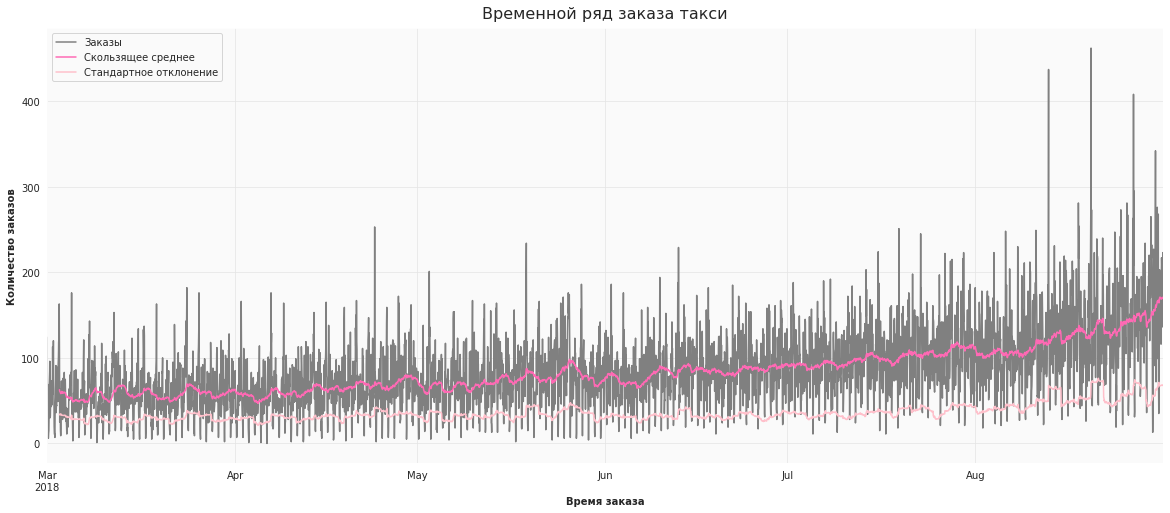

In [22]:
analitics = pd.DataFrame(index=data.index)
analitics['Заказы'] = data['num_orders']
analitics['Скользящее среднее'] = data['num_orders'].rolling(50).mean()
analitics['Стандартное отклонение'] = data['num_orders'].rolling(50).std()

fig, ax = plt.subplots(figsize=(20, 8))
analitics['Заказы'].plot(ax=ax, color='gray', label='Заказы')
analitics['Скользящее среднее'].plot(ax=ax, color='hotpink', label='Скользящее среднее')
analitics['Стандартное отклонение'].plot(ax=ax, color='pink', label='Стандартное отклонение')

ax.set_title('Временной ряд заказа такси')
ax.set_xlabel('Время заказа')
ax.set_ylabel('Количество заказов')
ax.grid(True)
ax.legend()

plt.show()

### Тренд. Сезонность. Остаток

In [23]:
decomposed_data = seasonal_decompose(data)

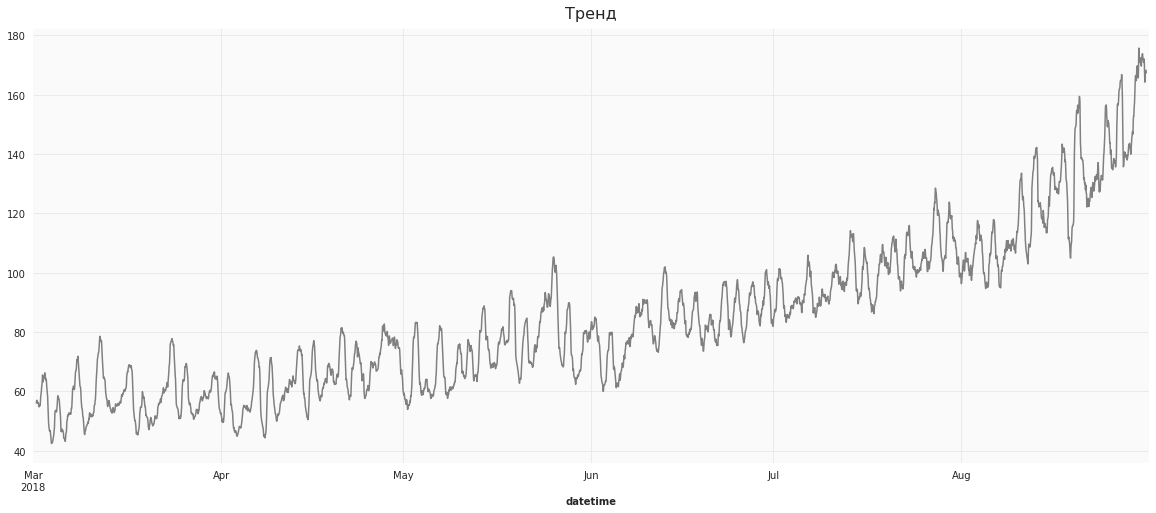

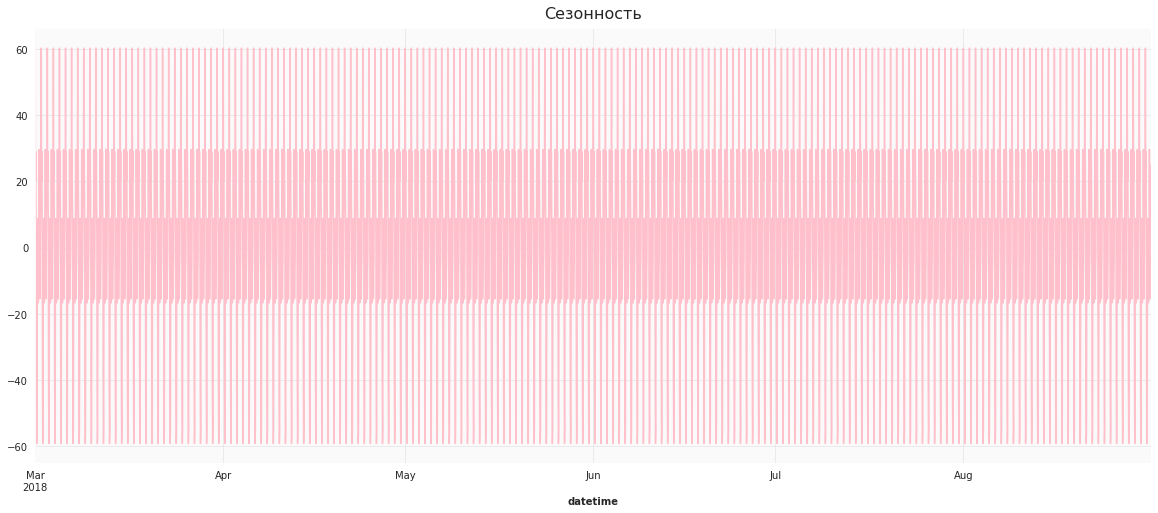

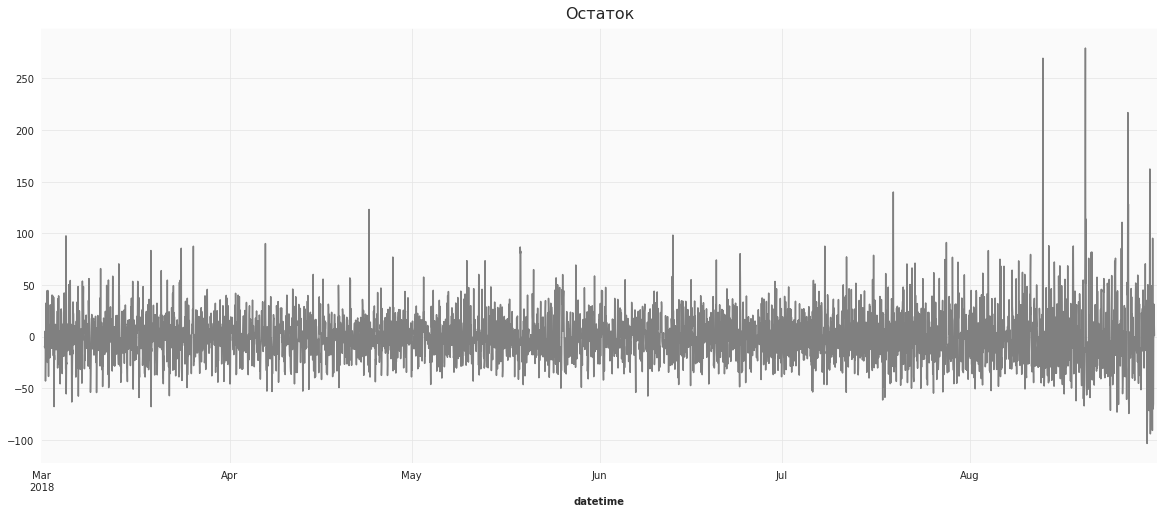

In [24]:
plt.figure(figsize=(20, 8))
decomposed_data.trend.plot(ax=plt.gca(), color='gray')
plt.title('Тренд')
plt.show()

plt.figure(figsize=(20, 8))
decomposed_data.seasonal.plot(ax=plt.gca(), color='pink')
plt.title('Сезонность')
plt.show()

plt.figure(figsize=(20, 8))
decomposed_data.resid.plot(ax=plt.gca(), color='gray')
plt.title('Остаток')
plt.show()

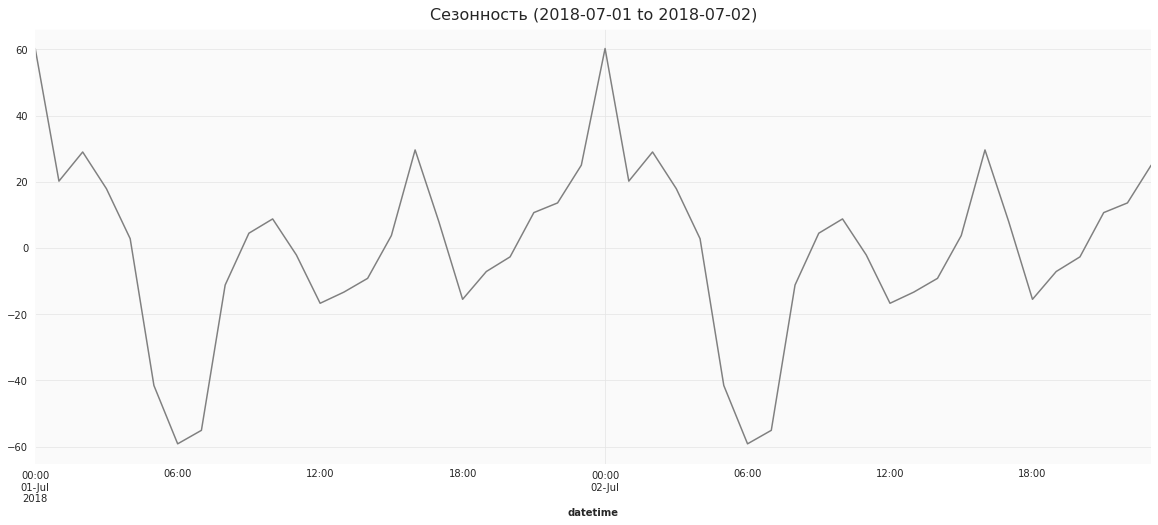

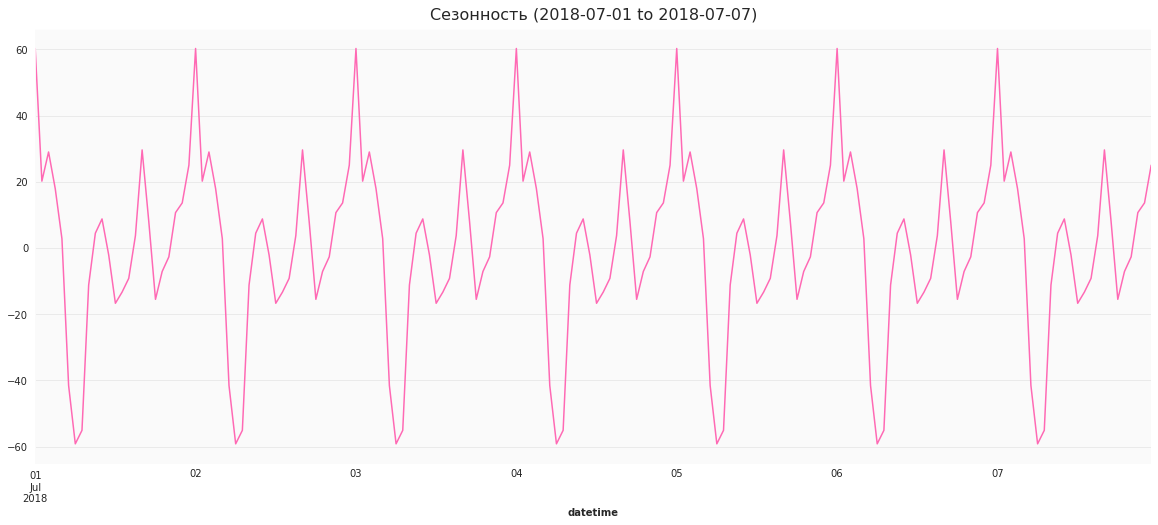

In [25]:
# Визуализируем сезонность за период 2018-07-01 по 2018-07-02
plt.figure(figsize=(20, 8))
decomposed_data.seasonal['2018-07-01':'2018-07-02'].plot(ax=plt.gca(), color='gray')
plt.title('Сезонность (2018-07-01 to 2018-07-02)')
plt.show()

# Визуализируем сезонность за период 2018-07-01 по 2018-07-07
plt.figure(figsize=(20, 8))
decomposed_data.seasonal['2018-07-01':'2018-07-07'].plot(ax=plt.gca(), color='hotpink')
plt.title('Сезонность (2018-07-01 to 2018-07-07)')
plt.show()

**Анализ временного ряда показывает нам следующие наблюдения:**  

>`Положительная тенденция движения временной оси:` Мы видим, что график имеет очевидную положительную тенденцию вправо, что указывает на рост количества заказов такси. Вероятно, это связано с ростом компании, успешными маркетинговыми акциями или стратегиями, которые помогают привлекать больше клиентов и обгонять конкурентов  

>`Сезонность в данных:` Наблюдается сезонность по часам, с максимальным количеством заказов каждый день в 12 часов ночи и минимумом в 6 утра. Это указывает на особенности пассажиропотока в зависимости от времени суток, где есть пиковые часы или наоборот, часы низкого спроса  

**NB!** данные только за полгода усложняют детальное выявление сезонности по месяцам. Тем не менее, мы можем наблюдать общую тенденцию  

>`Неcтационарность временного ряда:` Анализ показал, что временной ряд не является стационарным, так как среднее отклонение и среднее значение не являются постоянными. Это может затруднить прогнозирование и потребовать дополнительной обработки данных для улучшения моделей прогнозирования  

>`Прогнозирование и улучшение:` Для дальнейшей работы и прогнозирования данных, необходимо будет применить методы стационарности, такие как дифференцирование, чтобы привести ряд к стационарному виду. Это поможет улучшить метрики и точность прогнозов  

В итоге, исходя из текущего анализа, у нас есть интересные направления для дальнейшего исследования, которые могут помочь лучше понять особенности бизнеса и принять обоснованные решения для улучшения услуг и прогнозирования спроса  

## Обучение

Функция horizon_one_step выполняет подготовку данных для обучения моделей прогнозирования

In [26]:
def horizon_one_step(data, max_lag, min_roll):
    
    df = data.copy()
    
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(min_roll).mean()
    
    return df
    
    
one_step = horizon_one_step(data, 500, 50)
display(one_step.tail(5))

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,...,lag_452,lag_453,lag_454,lag_455,lag_456,lag_457,lag_458,lag_459,lag_460,lag_461,lag_462,lag_463,lag_464,lag_465,lag_466,lag_467,lag_468,lag_469,lag_470,lag_471,lag_472,lag_473,lag_474,lag_475,lag_476,lag_477,lag_478,lag_479,lag_480,lag_481,lag_482,lag_483,lag_484,lag_485,lag_486,lag_487,lag_488,lag_489,lag_490,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,2018,8,31,4,207.000,217.000,197.000,116.000,133.000,166.000,136.000,167.000,191.000,203.000,182.000,46.000,35.000,78.000,268.000,99.000,230.000,194.000,276.000,246.000,158.000,198.000,142.000,72.000,177.000,342.000,254.000,156.000,91.000,154.000,173.000,156.000,227.000,226.000,166.000,39.000,13.000,56.000,186.000,193.000,232.000,217.000,216.000,265.000,177.000,...,185.000,118.000,135.000,98.000,82.000,78.000,115.000,153.000,149.000,104.000,120.000,123.000,81.000,108.000,108.000,97.000,24.000,22.000,51.000,111.000,136.000,157.000,177.000,174.000,155.000,89.000,105.000,84.000,102.000,62.000,122.000,174.000,143.000,73.000,53.000,63.000,81.000,140.000,120.000,106.000,33.000,56.000,55.000,126.000,171.000,175.000,226.000,249.000,162.000,169.640
2018-08-31 20:00:00,154,2018,8,31,4,136.000,207.000,217.000,197.000,116.000,133.000,166.000,136.000,167.000,191.000,203.000,182.000,46.000,35.000,78.000,268.000,99.000,230.000,194.000,276.000,246.000,158.000,198.000,142.000,72.000,177.000,342.000,254.000,156.000,91.000,154.000,173.000,156.000,227.000,226.000,166.000,39.000,13.000,56.000,186.000,193.000,232.000,217.000,216.000,265.000,...,160.000,185.000,118.000,135.000,98.000,82.000,78.000,115.000,153.000,149.000,104.000,120.000,123.000,81.000,108.000,108.000,97.000,24.000,22.000,51.000,111.000,136.000,157.000,177.000,174.000,155.000,89.000,105.000,84.000,102.000,62.000,122.000,174.000,143.000,73.000,53.000,63.000,81.000,140.000,120.000,106.000,33.000,56.000,55.000,126.000,171.000,175.000,226.000,249.000,169.180
2018-08-31 21:00:00,159,2018,8,31,4,154.000,136.000,207.000,217.000,197.000,116.000,133.000,166.000,136.000,167.000,191.000,203.000,182.000,46.000,35.000,78.000,268.000,99.000,230.000,194.000,276.000,246.000,158.000,198.000,142.000,72.000,177.000,342.000,254.000,156.000,91.000,154.000,173.000,156.000,227.000,226.000,166.000,39.000,13.000,56.000,186.000,193.000,232.000,217.000,216.000,...,273.000,160.000,185.000,118.000,135.000,98.000,82.000,78.000,115.000,153.000,149.000,104.000,120.000,123.000,81.000,108.000,108.000,97.000,24.000,22.000,51.000,111.000,136.000,157.000,177.000,174.000,155.000,89.000,105.000,84.000,102.000,62.000,122.000,174.000,143.000,73.000,53.000,63.000,81.000,140.000,120.000,106.000,33.000,56.000,55.000,126.000,171.000,175.000,226.000,169.860
2018-08-31 22:00:00,223,2018,8,31,4,159.000,154.000,136.000,207.000,217.000,197.000,116.000,133.000,166.000,136.000,167.000,191.000,203.000,182.000,46.000,35.000,78.000,268.000,99.000,230.000,194.000,276.000,246.000,158.000,198.000,142.000,72.000,177.000,342.000,254.000,156.000,91.000,154.000,173.000,156.000,227.000,226.000,166.000,39.000,13.000,56.000,186.000,193.000,232.000,217.000,...,437.000,273.000,160.000,185.000,118.000,135.000,98.000,82.000,78.000,115.000,153.000,149.000,104.000,120.000,123.000,81.000,108.000,108.000,97.000,24.000,22.000,51.000,111.000,136.000,157.000,177.000,174.000,155.000,89.000,105.000,84.000,102.000,62.000,122.000,174.000,143.000,73.000,53.000,63.000,81.000,140.000,120.000,106.000,33.000,56.000,55.000,126.000,171.000,175.000,169.660
2018-08-31 23:00:00,205,2018,8,31,4,223.000,15

In [27]:
# Разделяем выборку на train (80%) и test_valid (20%)

train, test_valid = train_test_split(one_step, test_size=0.2, shuffle=False)

# Разделяем test_valid на valid (50%) и test (50%)

valid, test = train_test_split(test_valid, test_size=0.5, shuffle=False)

train = train.dropna()
valid = valid.dropna()
test = test.dropna()

# Выводим информацию о временных периодах каждой выборки

print("Train период: {} - {}".format(train.index.min(), train.index.max()))
print("Valid период: {} - {}".format(valid.index.min(), valid.index.max()))
print("Test период: {} - {}".format(test.index.min(), test.index.max()))

Train период: 2018-03-21 20:00:00 - 2018-07-26 03:00:00
Valid период: 2018-07-26 04:00:00 - 2018-08-13 13:00:00
Test период: 2018-08-13 14:00:00 - 2018-08-31 23:00:00


In [28]:
# Разделим выборку на признаки и таргет

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [29]:
# Линейная регрессия

model_lr = LinearRegression().fit(features_train, target_train)

preds_lr = model_lr.predict(features_valid)

rmse_lr = np.sqrt(mean_squared_error(target_valid, preds_lr))

print("RMSE валидационной выборке:", rmse_lr)

RMSE валидационной выборке: 29.02488948719388


In [30]:
def one_step_plot(preds_of_model, target_valid, model):

    preds = pd.DataFrame(data=preds_of_model, index=target_valid.index)
    plot_data = target_valid['2018-08-01':'2018-08-13']
    preds = preds['2018-08-01':'2018-08-13']

    plt.figure(figsize=(15, 5))
    plt.plot(plot_data, color='gray', label='История')
    plt.plot(preds, color='hotpink', label='Предсказание модели')
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(f'Прогнозирование с горизонтом в один шаг на {model}', fontsize=16)
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(plot_data['2018-08-13':'2018-08-13T13:00:00'], color='gray', label='История')
    plt.plot(preds['2018-08-13T13:00:00':'2018-08-13T13:00:00'], color='hotpink', label='Прогноз на час вперёд', marker='o')
    plt.legend()
    plt.xticks(plot_data['2018-08-13':'2018-08-13T13:00:00'].index, rotation=45)
    plt.title(f'Точечный прогноз на {model} за последний день', fontsize=16)
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.show()

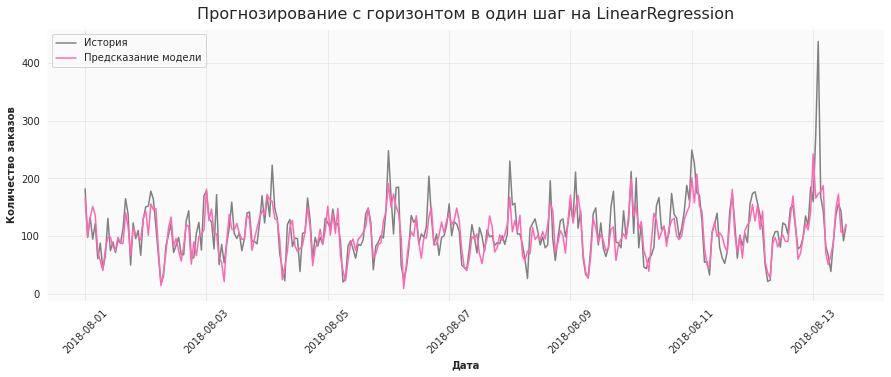

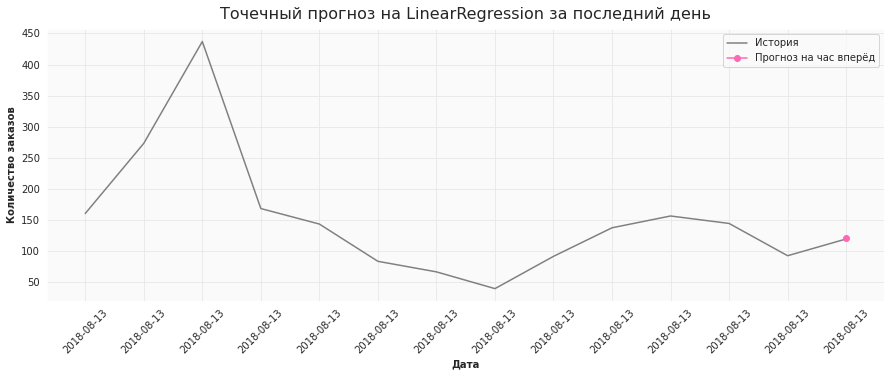

In [31]:
one_step_plot(preds_lr, target_valid, 'LinearRegression')

In [32]:
# Ridge

model_r = Ridge().fit(features_train, target_train)

preds_r = model_r.predict(features_valid)

rmse_r = np.sqrt(mean_squared_error(target_valid, preds_r))

print("RMSE валидационной выборке:", rmse_r)

RMSE валидационной выборке: 29.01814678775738


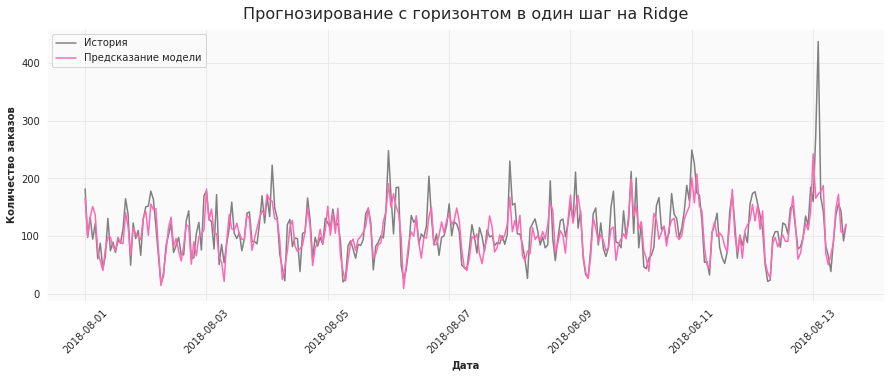

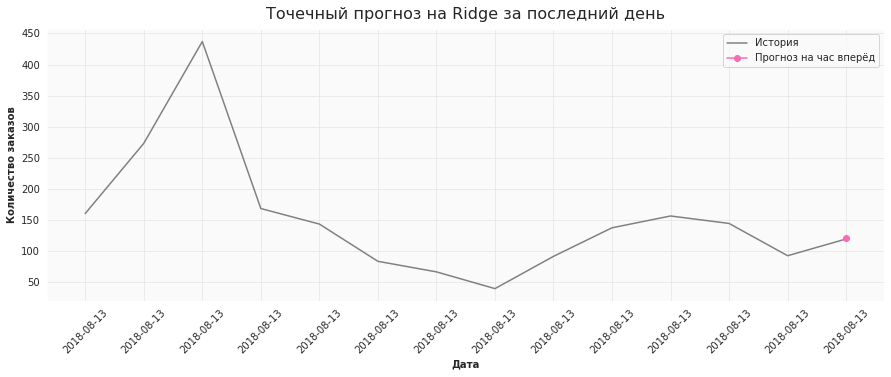

In [33]:
one_step_plot(preds_r, target_valid, 'Ridge')

In [34]:
# Random Forest

model_rfr = RandomForestRegressor().fit(features_train, target_train)

preds_rfr = model_rfr.predict(features_valid)

rmse_rfr = np.sqrt(mean_squared_error(target_valid, preds_rfr))

print("RMSE валидационной выборке:", rmse_rfr)

RMSE валидационной выборке: 29.517320254769476


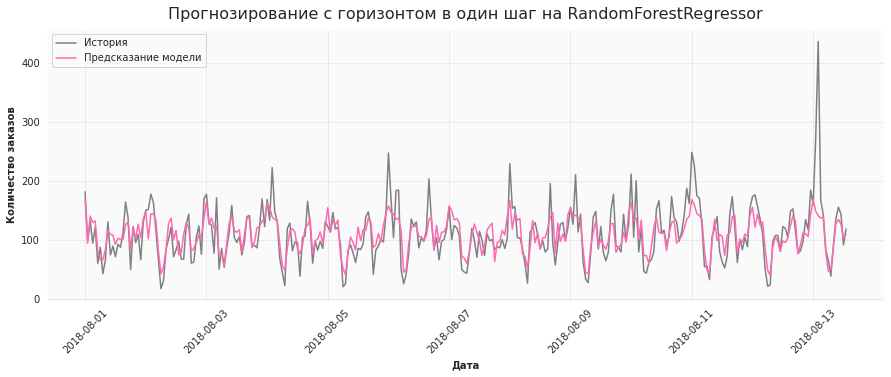

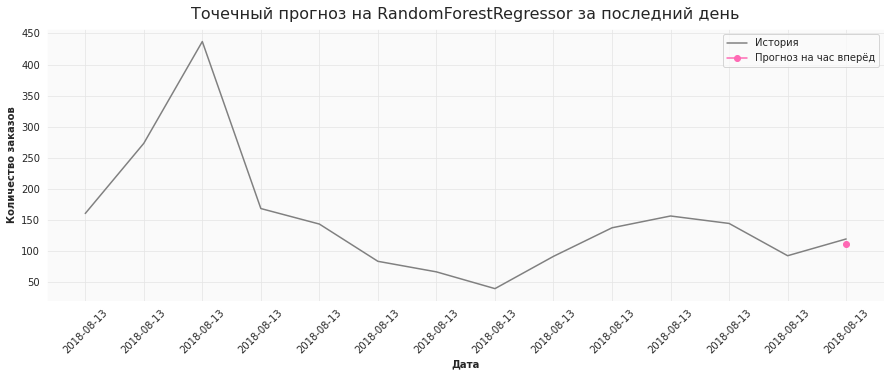

In [35]:
one_step_plot(preds_rfr, target_valid, 'RandomForestRegressor')

In [36]:
# Cat Boost

model_cbr = CatBoostRegressor(loss_function='RMSE', silent=True).fit(features_train, target_train)

preds_cbr = model_cbr.predict(features_valid)

rmse_cbr = np.sqrt(mean_squared_error(target_valid, preds_cbr))

print("RMSE валидационной выборке:", rmse_cbr)

RMSE валидационной выборке: 29.355679890980106


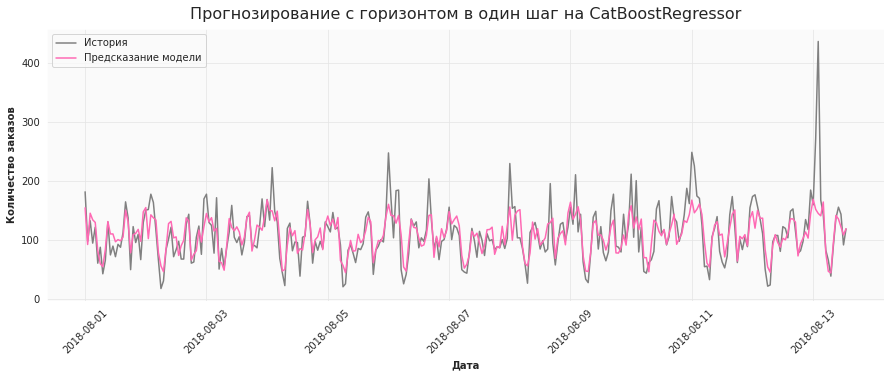

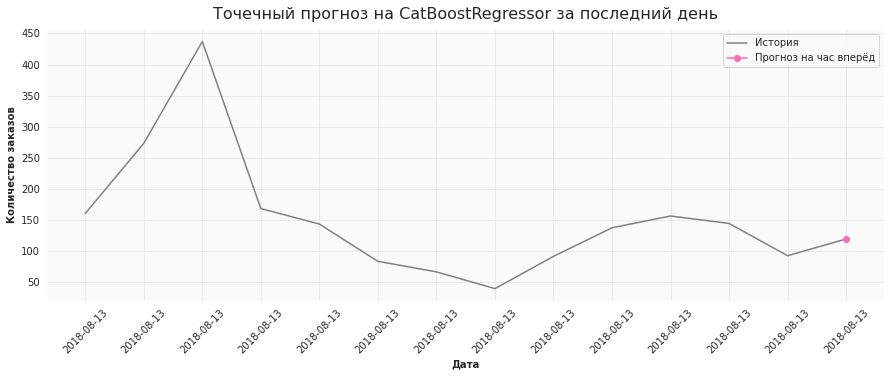

In [37]:
one_step_plot(preds_cbr, target_valid, 'CatBoostRegressor')

In [38]:
# XGBoost

model_xgb = xgb.XGBRegressor().fit(features_train, target_train)

preds_xgb = model_xgb.predict(features_valid)

rmse_xgb = np.sqrt(mean_squared_error(target_valid, preds_xgb))

print("RMSE валидационной выборке:", rmse_xgb)

RMSE валидационной выборке: 32.7196913140421


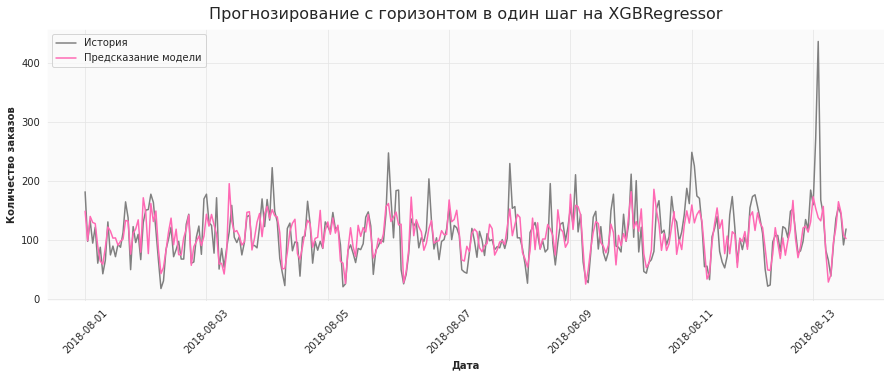

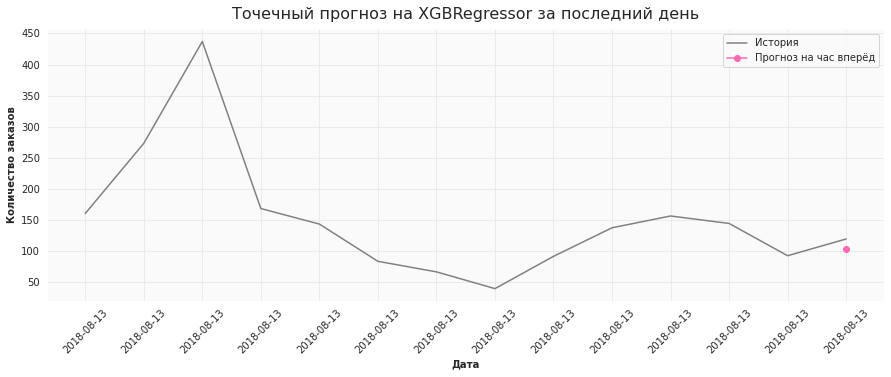

In [39]:
one_step_plot(preds_xgb, target_valid, 'XGBRegressor')

In [40]:
models = pd.DataFrame(data=[rmse_lr, rmse_rfr, rmse_cbr, rmse_xgb, rmse_r],
                      columns = ['RMSE'],
                      index = [['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'XGBRegressor', 'Ridge']])
models.sort_values(by='RMSE')

,RMSE
Ridge,29.018
LinearRegression,29.025
CatBoostRegressor,29.356
RandomForestRegressor,29.517
XGBRegressor,32.720


### Сравнение моделей

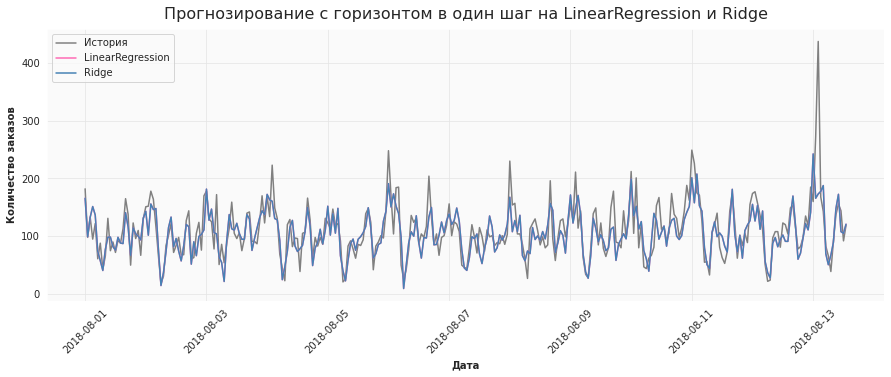

In [41]:
models = {'LinearRegression': preds_lr, 'Ridge': preds_r}
plot_data = target_valid['2018-08-01':'2018-08-13']

plt.figure(figsize=(15, 5))
plt.plot(plot_data, color='gray', label='История')

colors = ['hotpink', 'steelblue']

for i, (model_name, preds) in enumerate(models.items()):
    preds_plot = pd.DataFrame(data=preds, index=target_valid.index)
    preds_plot = preds_plot['2018-08-01':'2018-08-13']
    plt.plot(preds_plot, color=colors[i], label=model_name)

plt.legend()
plt.xticks(rotation=45)
plt.title('Прогнозирование с горизонтом в один шаг на LinearRegression и Ridge', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

#### Вывод:  

По полученным результатам можно сделать выводы:  

>RMSE (Root Mean Squared Error) - метрика, которая показывает, насколько сильно отличаются предсказанные значения от фактических. Чем меньше значение RMSE, тем лучше модель прогнозирует значения  

В данной задаче прогнозирования количества заказов такси на следующий час, линейные модели, такие как Ridge и LinearRegression, показали схожие результаты RMSE (около 29). Это говорит о том, что линейные модели могут хорошо обработать некоторую линейную зависимость в данных. Но они модели могут не учесть сложные нелинейные зависимости, которые могут присутствовать в данных  

`Модель CatBoostRegressor` показала `RMSE около 29.356`. CatBoost является градиентным бустингом на основе деревьев решений и может хорошо работать с категориальными признаками и сложными зависимостями между ними  

`Модели RandomForestRegressor` и `XGBRegressor` показали `RMSE около 29.517 и 32.720` соответственно. Эти модели также основаны на ансамблевых методах деревьев решений, которые могут хорошо работать с нелинейными зависимостями и категориальными признаками  

При значении `RMSE 29` можно сделать вывод, что модель в среднем ошибается на 29 заказов такси при прогнозировании количества заказов на следующий час. Таким образом, значения RMSE в пределах 29 говорят о том, что модели в среднем допускают ошибку на уровне 29 заказов, что является не очень хорошим результатом, но похоже заказчик понимал, особенности периода в 6 месяцев и предусмотрительно поднял планку RMSE

Кроме того, можно обратить внимание, что модель `Ridge` показала лучший результат с `RMSE 29.018`, что делает ее более предпочтительной среди остальных  

Возможнотакже, требуется дополнительное исследование и настройка модели для достижения еще лучших результатов  

**Для улучшения результатов можно попробовать следующие подходы:**

* Использовать более сложные модели, например, SARIMA (Seasonal Autoregressive Integrated Moving Average) или нейронные сети, которые специально предназначены для работы с временными рядами  

* Подобрать более оптимальные гиперпараметры для моделей с помощью Grid Search или Random Search  

* Использовать дополнительные признаки или инженерию признаков, чтобы улучшить предсказания  

### Улучшение модели

In [42]:
# Определяем диапазоны для гиперпараметров
param_grid = {
    'alpha': [500, 200, 100, 50, 10, 1, 0.1, 0.01],
    'fit_intercept': [True, False],
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(Ridge(), param_grid, scoring='neg_root_mean_squared_error', cv=tscv)
grid_search.fit(features_train, target_train)

best_alpha = grid_search.best_params_['alpha']
best_fit_intercept = grid_search.best_params_['fit_intercept']
best_solver = grid_search.best_params_['solver']
best_rmse = -grid_search.best_score_

print(f'Лучшее RMSE на валидационной выборке: {best_rmse}')
print(f'Лучшие значения гиперпараметров:')
print(f'alpha: {best_alpha}')
print(f'fit_intercept: {best_fit_intercept}')
print(f'solver: {best_solver}')

Лучшее RMSE на валидационной выборке: 23.669971186445483
Лучшие значения гиперпараметров:
alpha: 500
fit_intercept: False
solver: sparse_cg


In [43]:
# Объединим признаки и целевую переменную для обучения и валидации

features_train = np.concatenate([features_train, features_valid])
target_train = target_train.append(target_valid)

# Параметры и модель для GridSearchCV

grid_params = {
    'alpha': [500, 200, 100, 50, 10, 1, 0.1, 0.01],
    'fit_intercept': [True, False],
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

tscv = TimeSeriesSplit(n_splits=5)
ridge_model = Ridge()

model = GridSearchCV(estimator=ridge_model, param_grid=grid_params, cv=tscv)

model.fit(features_train, target_train)

print("Лучшие параметры модели:", model.best_params_)

Лучшие параметры модели: {'alpha': 500, 'fit_intercept': False, 'solver': 'sparse_cg'}


## Тестирование

In [44]:
# Гиперпараметры модели

alpha_value = 500
fit_intercept_value = False
solver_value = 'sparse_cg'

# Модель Ridge с заданными гиперпараметрами

model = Ridge(alpha=alpha_value, fit_intercept=fit_intercept_value, solver=solver_value)
model.fit(features_train, target_train)
preds = model.predict(features_test)


rmse = np.sqrt(mean_squared_error(target_test, preds))
print("RMSE на тестовой выборке:", rmse)

RMSE на тестовой выборке: 34.8864489345953


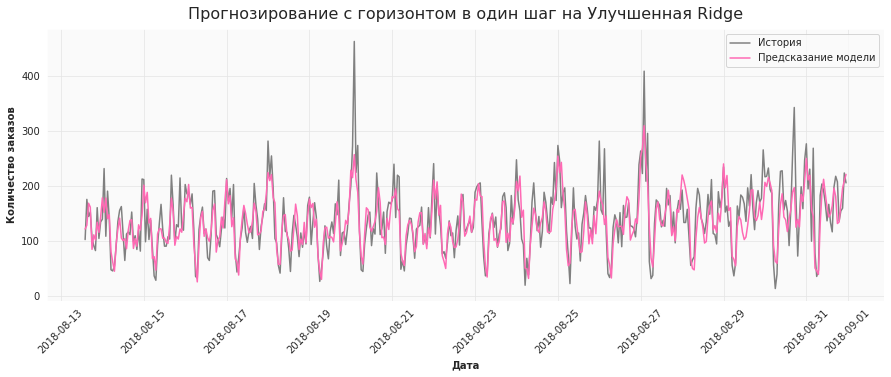

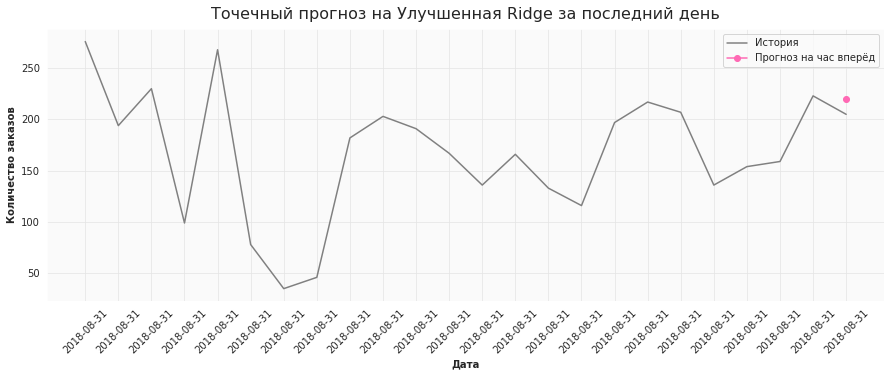

In [45]:
preds_r = model.predict(features_test)


preds_df = pd.DataFrame(data=preds_r, index=target_test.index)

plot_data = target_test
model = 'Улучшенная Ridge'

plt.figure(figsize=(15, 5))
plt.plot(plot_data, color='gray', label='История')
plt.plot(preds_df, color='hotpink', label='Предсказание модели')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'Прогнозирование с горизонтом в один шаг на {model}', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(plot_data['2018-08-31':'2018-08-31T23:00:00'], color='gray', label='История')
plt.plot(preds_df['2018-08-31T23:00:00':'2018-08-31T23:00:00'], color='hotpink', label='Прогноз на час вперёд', marker='o')
plt.legend()
plt.xticks(plot_data['2018-08-31':'2018-08-31T23:00:00'].index, rotation=45)
plt.title(f'Точечный прогноз на {model} за последний день', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()